<a href="https://colab.research.google.com/github/rahul13ramesh/cis520-dataset/blob/master/CIS520_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-520 Project -[What's cooking](https://www.kaggle.com/c/whats-cooking-kernels-only)

* This notebook looks at the Kaggle contest *What's cooking*. We tackle a supervised and unsupervised learning problem using this dataset
* The input features are a collection of words and hence NLP techniques are used to build useful features for the downstream task

In [1]:
!pip install pywaffle
!git clone https://github.com/amueller/word_cloud.git
!cd word_cloud && pip install .

     |████████████████████████████████| 532kB 6.6MB/s 
Cloning into 'word_cloud'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 4070 (delta 202), reused 317 (delta 163), pack-reused 3692
Receiving objects: 100% (4070/4070), 77.39 MiB | 26.10 MiB/s, done.
Resolving deltas: 100% (2258/2258), done.
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post1+g8217e20-cp36-cp36m-linux_x86_64.whl size=335558 sha256=136671e099f5fb63cf77532fd69e530c7392e750d0fdba371569171483d3a073
  Stored in directory: /tmp/pip-ephem-wheel-cache-ycpn7g05/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


In [0]:
import numpy as np
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pywaffle import Waffle

In [3]:
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json

--2019-11-30 00:42:51--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2844086 (2.7M) [text/plain]
Saving to: ‘test.json’

test.json           100%[===================>]   2.71M  --.-KB/s    in 0.05s   

2019-11-30 00:42:51 (57.8 MB/s) - ‘test.json’ saved [2844086/2844086]

--2019-11-30 00:42:54--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12415067 (12M) [text/plain]
Saving 

# Loading dataset
We load the dataset and display a single entry from this dataset

In [0]:
with open("test.json", "r") as f:
    test_data = json.load(f)
with open("train.json", "r") as f:
    train_data = json.load(f)

In [5]:
train_data[0]

{'cuisine': 'greek',
 'id': 10259,
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

# Data analysis and Visualization

The aim of this analysis is as follows:

* Gain an understanding of the dataset, distribution of labels and number of data points. 
* Look for potentially useful features that can help an classifier achieve higher accuracies.
* Look for anamolies in data that need to be handled through data pre-processing and cleaning. 

### Preliminary Understanding of Data

In [6]:
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)
cuisines = train_data_df["cuisine"].unique()
print("Data size: " + str(train_data_df.shape))
print("Numerb of cuisines: ", str(len(cuisines)))

Data size: (39774, 3)
Numerb of cuisines:  20


In [7]:
train_data_df.groupby(by='cuisine').count().sort_values(by='ingredients',ascending=False)

,id,ingredients
cuisine,,
italian,7838,7838
mexican,6438,6438
southern_us,4320,4320
indian,3003,3003
chinese,2673,2673
french,2646,2646
cajun_creole,1546,1546
thai,1539,1539
japanese,1423,1423


In [8]:
print(train_data_df.head())

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...


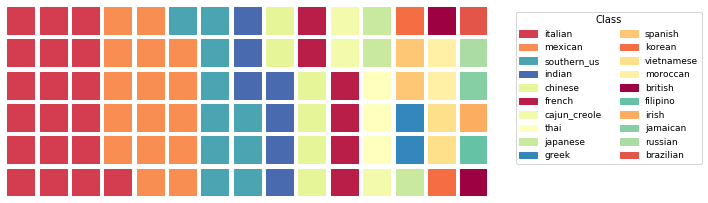

In [9]:
# Waffle Plot of data distribution
class_data = train_data_df.cuisine.value_counts()
class_data = ((class_data)*100) // class_data.values.sum()
colors = [plt.cm.Spectral(i/float(len(cuisines))) for i in range(len(cuisines))]
np.random.seed(5)
np.random.shuffle(colors)

plt.figure(
    figsize=(10, 12),
    FigureClass=Waffle, 
    rows=6,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 9, 'title':'Class', 'ncol': 2},
    values=class_data.values,
    labels=list(class_data.index),
    colors=colors
)
plt.show()

### Analysis of Recipes

In [0]:
# Get space seperated text of all the ingredients
text = ''
for i in range(train_data_df.shape[0]):
    text = text + " " + ' '.join(train_data_df.iloc[i, 2])

# Get all ingredients as a list (along with cuisine, and number of ingredients for each ingredient)
text_list = []
text_list_cuisine = []
text_list_num = []
for i in range(train_data_df.shape[0]):
    text_list = text_list + train_data_df.iloc[i, 2]
    len_ing = len(train_data_df.iloc[i, 2])
    text_list_cuisine = text_list_cuisine + [train_data_df.iloc[i, 1] for i in range(len_ing)]
    text_list_num = text_list_num + [len_ing for i in range(len_ing)]

In [0]:
def get_ingredients(cuisine_val):
    """
    Get all the ingredients for a particular cuisine
    """
    text = ''
    for i in range(train_data_df.shape[0]):
        if cuisine_val == train_data_df.iloc[i, 1]:
            text = text + " " + ' '.join(train_data_df.iloc[i, 2])
    return text
    
def get_num_ingredients(cuisine_val):
    """
    Get the number of ingredients of each recipe for a particular cuisine
    """
    num = []
    for i in range(train_data_df.shape[0]):
        if cuisine_val == train_data_df.iloc[i, 1]:
            num.append(len(train_data_df.iloc[i,2]))
    return num

def plot_word_cloud(txt, coloc=True):
    """
    Plot the word cloud corresponding to some text
    """
    wordcloud = WordCloud(background_color="white", collocations=coloc).generate(txt)
    plt.figure(figsize = (7, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

We first plot word clouds based on the ingredients to understand the nature of the data

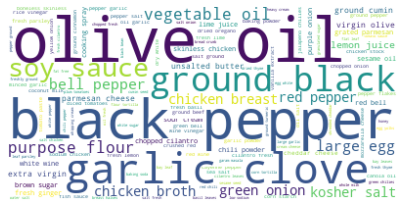

In [12]:
# Plot word cloud for entire data
plot_word_cloud(text,True)

We next look at the word-clouds in a per cuisine granularity. The visualizations show that the key ingredients in a recipes vary significantly with the cuisine

In [0]:
cuisine_ingredients = {}
cuisine_numbers = {}
for c in cuisines:
    cuisine_ingredients[c] = get_ingredients(c)
    cuisine_numbers[c] = get_num_ingredients(c)

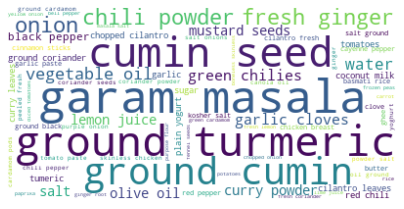

In [14]:
plot_word_cloud(cuisine_ingredients['indian'])

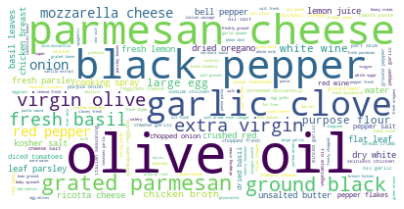

In [15]:
plot_word_cloud(cuisine_ingredients['italian'])

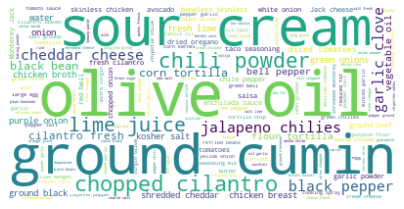

In [16]:
plot_word_cloud(cuisine_ingredients['mexican'])

Next we look use Violin-plots (box plots) to understand how  the number of ingredients varies with cuisine. The plots indicate that this feature can be used a useful feature for a classifier.

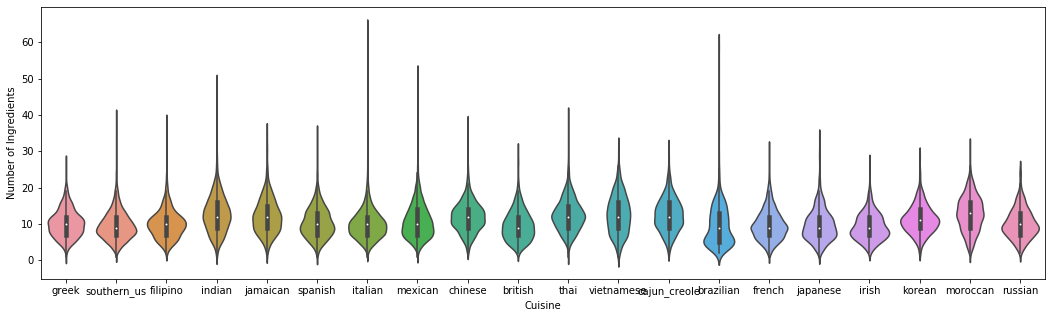

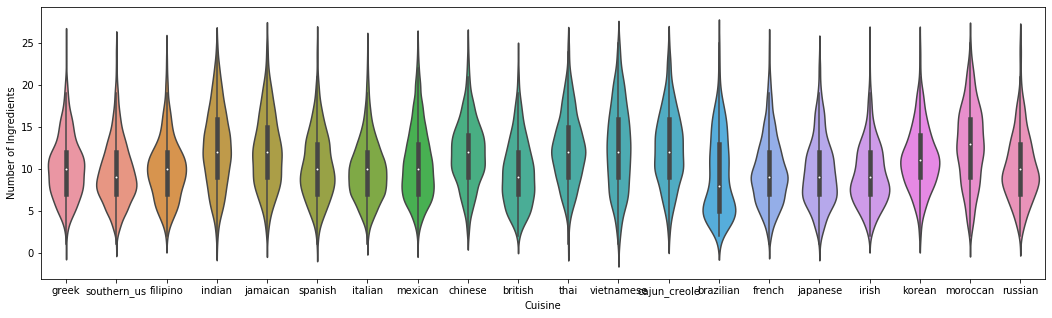

In [17]:
cuisine_num_array = []
cuisine_val = []
for c in cuisines:
    cuisine_num_array = cuisine_num_array + cuisine_numbers[c]
    cuisine_val = cuisine_val + [c for _ in range(len(cuisine_numbers[c]))]
cuisine_number_df = pd.DataFrame([cuisine_num_array, cuisine_val]).T
cuisine_number_df.columns = ["Number of Ingredients", "Cuisine"]
cuisine_number_df["Number of Ingredients"] = pd.to_numeric(cuisine_number_df["Number of Ingredients"])

plt.figure(figsize=(18,5))
sns.violinplot(x="Cuisine", y="Number of Ingredients", data=cuisine_number_df)

plt.figure(figsize=(18,5))
sns.violinplot(x="Cuisine", y="Number of Ingredients", data=cuisine_number_df[cuisine_number_df["Number of Ingredients"] <= 25])
plt.show()

In [0]:
long_ingredients = []
small_ingredients1 = []
small_ingredients2 = []
small_ingredients3 = []
for i in range(train_data_df.shape[0]):
    ing =  train_data_df.iloc[i, 2]
    if len(ing) >= 30:
        long_ingredients.append((ing, train_data_df.iloc[i, 1]))
    elif len(ing) == 1:
        small_ingredients1.append((ing, train_data_df.iloc[i, 1]))
    elif len(ing) == 2:
        small_ingredients2.append((ing, train_data_df.iloc[i, 1]))
    elif len(ing) == 3:
        small_ingredients3.append((ing, train_data_df.iloc[i, 1]))

In [19]:
print("Number of long ingredients: " + str(len(long_ingredients)))
print("Number of short ingredients: " + str(len(small_ingredients1)))
print("Number of short ingredients: " + str(len(small_ingredients2)))
print("Number of short ingredients: " + str(len(small_ingredients3)))

Number of long ingredients: 55
Number of short ingredients: 22
Number of short ingredients: 193
Number of short ingredients: 549


In [20]:
small_ingredients1
# Remove elements with just 1 ingredients, clearly

[(['sushi rice'], 'japanese'),
 (['dried rice noodles'], 'vietnamese'),
 (['plain low-fat yogurt'], 'indian'),
 (['unsalted butter'], 'indian'),
 (['udon'], 'japanese'),
 (['sticky rice'], 'thai'),
 (['butter'], 'indian'),
 (['corn tortillas'], 'mexican'),
 (['grained'], 'thai'),
 (['lemonade concentrate'], 'southern_us'),
 (['jasmine rice'], 'thai'),
 (['unsalted butter'], 'indian'),
 (['cherry tomatoes'], 'italian'),
 (['butter'], 'french'),
 (['cumin seed'], 'indian'),
 (['haricots verts'], 'french'),
 (['vegetable oil'], 'mexican'),
 (['spanish chorizo'], 'spanish'),
 (['sweetened condensed milk'], 'spanish'),
 (['water'], 'japanese'),
 (['phyllo'], 'greek'),
 (['unsalted butter'], 'indian')]

In [21]:
small_ingredients2[0:5]

[(['water', 'barley'], 'korean'),
 (['granulated sugar', 'large egg whites'], 'mexican'),
 (['aged gouda', 'soppressata'], 'italian'),
 (['melted butter', 'potatoes'], 'italian'),
 (['water', 'medium-grain rice'], 'korean')]

In [22]:
small_ingredients3[0:5]

[(['sweetened condensed milk', 'ice', 'espresso'], 'vietnamese'),
 (['chocolate bars', 'marshmallows', 'cinnamon graham crackers'], 'mexican'),
 (['kale leaves', 'chicken noodle soup', 'cannellini beans'], 'italian'),
 (['dashi kombu', 'dried bonito flakes', 'water'], 'japanese'),
 (['sweetened condensed milk', 'butter', 'cocoa powder'], 'brazilian')]

In [23]:
print(long_ingredients[0])

(['sugar', 'fresh cilantro', 'hoisin sauce', 'butter', 'crushed red pepper flakes', 'strawberries', 'ground coriander', 'red bell pepper', 'adobo sauce', 'green peppercorns', 'kosher salt', 'salted butter', 'chives', 'sea salt', 'extra-virgin olive oil', 'taco seasoning', 'pork loin chops', 'chipotle peppers', 'chorizo sausage', 'blueberri preserv', 'orange', 'ground black pepper', 'balsamic vinegar', 'basil', 'garlic', 'filet', 'thyme leaves', 'chipotles in adobo', 'unsweetened cocoa powder', 'black pepper', 'honey', 'boneless skinless chicken breasts', 'heavy cream', 'cracked black pepper', 'coffee beans', 'garlic cloves', 'steak', 'onions'], 'filipino')


### Understanding Individual Ingredient / Tokens

In [0]:
text_analysis = text.lower()
# Remove elements
rem_elems = ["lb.", "oz.", "inch", "%", "™", "®",  "€", "(", ")", ","]
for e in rem_elems:
    text_analysis = text_analysis.replace(e, " ")
text_analysis = text_analysis.replace("’", "'")
text_analysis = ''.join([i for i in text_analysis if not i.isdigit()])
ing_analysis = text_analysis.split()

In [25]:
word_counts = []
print("Number of Ingredients: " + str(len(set(ing_analysis))))
for x in set(ing_analysis):
    word_counts.append((ing_analysis.count(x), x))

Number of Ingredients: 3092


In [26]:
sorted(word_counts, reverse=True)[0:10]

[(25742, 'pepper'),
 (24426, 'salt'),
 (23323, 'oil'),
 (18941, 'garlic'),
 (18256, 'ground'),
 (17853, 'fresh'),
 (13129, 'sauce'),
 (12493, 'sugar'),
 (12341, 'onions'),
 (11776, 'cheese')]

In [0]:
ing_count_df = pd.DataFrame(word_counts)
ing_count_df.columns = ["Count", "Ingredient"]

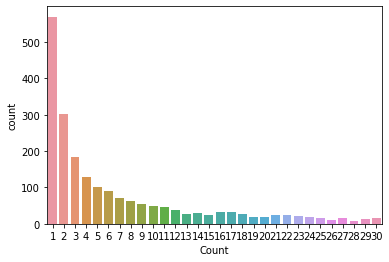

In [28]:
sns.countplot(data=ing_count_df[ing_count_df.Count <= 30], x="Count")
# About 600 entries

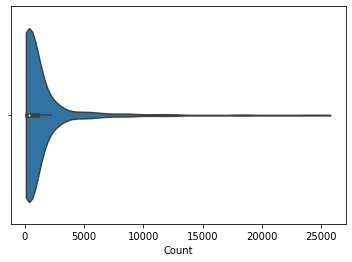

In [29]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sns.violinplot(data=ing_count_df[(ing_count_df["Count"] >= 100)], x="Count", cut=0)

### Understanding character Set

We now look to get an understanding of the frequency of occurence of words in an ingredient. In particular we would like to look at ingredients with special characters.

In [30]:
print(' '.join(sorted(set(text))))
# Convert upper case to lower case

  ! % & ' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z ® â ç è é í î ú ’ € ™


8	italian		1% low-fat milk
9	mexican		2% reduced-fat milk
7	greek		2% reduced-fat milk
10	greek		1% low-fat cottage cheese
9	southern_us		1% low-fat milk
13	indian		1% low-fat milk
21	mexican		1% low-fat milk
15	filipino		1% low-fat milk
18	filipino		1% low-fat milk
6	jamaican		(10 oz.) frozen chopped spinach, thawed and squeezed dry


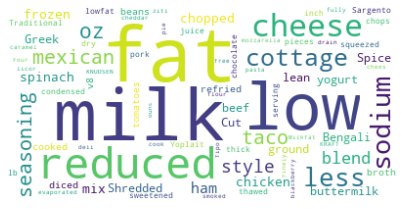

In [31]:
count = 0
digit_char = []

for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if any(char.isdigit() for char in ing):
        count += 1
        if count <= 10:
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        digit_char.append([num, cuisine, ing])
# remove numbers number/number, number%, num.number
#  add presense of number as feature?
tmp_text = ' '.join([row[2] for row in digit_char])
plot_word_cloud(tmp_text, False)

In [32]:
for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if "€" in ing:
        print(str(num) + "\t" + cuisine + "\t\t" + ing)
# remove the pound character, since only one item has character

6	greek		hellmannâ€™ or best food canola cholesterol free mayonnais


9	greek		Bertolli® Classico Olive Oil
8	greek		Old El Paso™ mild red enchilada sauce
8	southern_us		Pillsbury™ Refrigerated Crescent Dinner Rolls
6	indian		Sargento® Traditional Cut Shredded Mozzarella Cheese
8	southern_us		Country Crock® Spread
11	italian		Old El Paso™ chopped green chiles
6	southern_us		Country Crock® Spread
5	indian		Knorr® Beef Bouillon
14	spanish		OREO® Cookies
11	spanish		I Can't Believe It's Not Butter!® Spread
209


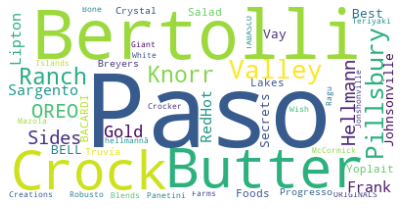

In [33]:
count = 0
copyright_char = []

for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if "®" in ing or ("™" in ing):
        count += 1
        if count <= 10:
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        copyright_char.append([num, cuisine, ing])
print(len(copyright_char))
tmp_text = ""
for row in copyright_char:
    for w in row[2].split():
        if ("®" in w )or ("™" in w):
            tmp_text = tmp_text + " " + w 
plot_word_cloud(tmp_text,False)

12	italian		half & half
16	spanish		half & half
12	italian		half & half
13	chinese		half & half
7	indian		half & half
11	southern_us		half & half
11	spanish		I Can't Believe It's Not Butter!® Spread
5	greek		I Can't Believe It's Not Butter!® Spread
5	filipino		I Can't Believe It's Not Butter!® Spread
9	mexican		I Can't Believe It's Not Butter!® All Purpose Sticks
13	mexican		I Can't Believe It's Not Butter!® Spread
10	spanish		I Can't Believe It's Not Butter!® All Purpose Sticks


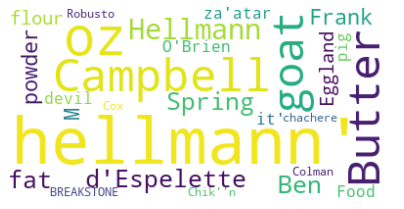

In [34]:
count1 = 0
count2 = 0
spl_char = []

for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if ("!" in ing) or ("&" in ing) or ("(" in ing) or (")" in ing) or ("'" in ing) or ("%" in ing):
        if count1 <= 5 and ('!' in ing):
            count1 += 1
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        spl_char.append([num, cuisine, ing])

        if count2 <= 5 and ('&' in ing):
            count2 += 1
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        spl_char.append([num, cuisine, ing])

tmp_text = ""
for row in spl_char:
    for w in row[2].split():
        if ("!" in w) or ("&" in w) or ("(" in w) or (")" in w) or ("'" in w) or ("%" in w):
            tmp_text = tmp_text + " " + w 
plot_word_cloud(tmp_text, False)
# replace & with and maybe (half & half)
# Remove %, (, )
# ' occurs for plural

#There are some spelling errors for example
#believ as seen below
# ! occurs for a brand "I can't Believe ti's Not Butter"

9	southern_us		pumpkin purée
7	indian		kahlúa
14	mexican		kahlúa
11	mexican		kahlúa
5	southern_us		grated Gruyère cheese
20	indian		tomato purée
8	greek		sheep’s milk cheese
5	greek		Zatarain’s Jambalaya Mix
9	jamaican		sheep’s milk cheese
11	italian		sheep’s milk cheese
19	filipino		sheep’s milk cheese
8	indian		Breakstone’s Sour Cream


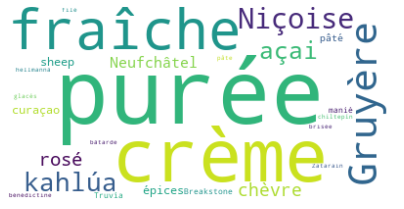

In [35]:
accented_char_set= ["â", "ç", "è", "é", "í", "î", "ú", "’"]
accented_char = []
count1 = 0
count2 = 0

for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if 1 in [c in ing for c in accented_char_set]:
        if count1 <= 5 and '’' in ing:
            count1 += 1
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        elif count2 <= 5:
            count2 += 1
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        accented_char.append([num, cuisine, ing])
    
tmp_text = ""
for row in accented_char:
    for w in row[2].split():
        if 1 in [c in w for c in accented_char_set]:
            tmp_text = tmp_text + " " + w 
plot_word_cloud(tmp_text, False)
# '’' Replace with apostrophe '

# Creating Features / Dataset Variants

https://www.kaggle.com/rejasupotaro/what-are-ingredients

* Make Upper case to lower case
* Remove elements with 1 ingredient
* Add feature for special characters â ç è é í î ú 
* Remove lb. inch oz.
* Add feature for:  ™ ® 
* Add feature for: !     (! used for a particular brand)
* Add feature for: Numbers/percentages
* Remove symbol: € ™ ( ) ® . - %
* Change ’ with ' (first one is a special character)
* Replace "&" with and  or space(not sure about this)
* Remove all numbers
* Remove all ,
* Add feature if ™ ® 
* If there are many ingredients, maybe pick a subset of ingredients as features?


# Training Classifiers

# Unsupservised learning

# TODO

* Look at the common words in each cuisine (see most overlapping words too)
* LDA
* K-means
* A number of words occur only one, what to do about these words?
* Choice of features (run evaluation)/different subsets - on subset
* Model hyper-paramters (run grid-search) - on subset

Let us analyse the dictionary of characters that are present

* Token/lemmatizing/capitalization, synonym identification, accented characters and number of ingredients

# Pre-processing

---



In [0]:
def create_train_test_data(train_data_df, test_data_df):
  train_recepies = [] 
  train_targets = []
  for ig_item in train_data_df['ingredients']:
      train_recepies.append(ig_item)
  for cuisine_item in train_data_df['cuisine']:
      train_targets.append(cuisine_item)

  # create test data only, no targets
  test_recepies = []
  for ig_item in test_data_df['ingredients']:
      test_recepies.append(ig_item)
  return train_recepies, train_targets, test_recepies

In [53]:
train_features, train_targets, test_features = create_train_test_data(train_data_df, test_data_df)
print(train_targets[0:5])

['greek', 'southern_us', 'filipino', 'indian', 'indian']


#### Remove small receipies, special characters, quantity classifiers (inch, oz etc.)


In [54]:
'inches' in text


False

In [56]:
import re

def process_features(features, targets, mode="train"):
  processed_recepie = []
  processed_cuisine = []
  count_len = []

  for idx, recepie in enumerate(features):
    processed_ingredient = []
    if mode=='train':
      cuisine_lower = targets[idx].lower()

    # Remove certain words
    for ingredient in recepie:
      ingredient = ingredient.lower()
      ingredient = re.sub((r'\b(pound|kg|lb|oz|ounc|inch)\b'), ' ', ingredient) # quantity classifiers removal
      #  ingredient = re.sub("[^a-zA-Z]"," ",ingredient) #special characters removal
      processed_ingredient.append(ingredient)
  
    if len(recepie) > 2:
      processed_recepie.append(processed_ingredient)
      if mode=='train':
        processed_cuisine.append(cuisine_lower)
    else:
      count_len.append(len(recepie))

  print('Removed {} small recepies from input data'.format(len(count_len)))
  print(count_len)
  if mode=='train':
    return processed_recepie, processed_cuisine
  else:
    return processed_recepie

processed_train_features, processed_train_target= process_features(train_features, train_targets, mode='train')
processed_test_features = process_features(test_features, train_targets,  mode='test') # just passing the targets, not using it while preprocessing test data


print('Sanity check --------------')
print(len(processed_train_target))
print(len(processed_train_features))

Removed 215 small recepies from input data
[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Removed 56 small recepies from input data
[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2]
Sanity check --------------
39559
39559


In [0]:
import re

def process_features(features, targets, mode="train"):
    processed_recepie = []
    processed_cuisine = []
    count_len = []

    for idx, recepie in enumerate(features):
        processed_ingredient = []
        if mode=='train':
            cuisine_lower = targets[idx].lower()

    # Remove certain words
    ingredient_all = ' '.join(recipe)
    ingredient_all = ingredient.lower()
    ingredient_all = re.sub((r'\b(pound|kg|lb|oz|ounc|inch)\b'), ' ', ingredient_all) # quantity classifiers removal
    
    processed_ingredient.append(ingredient)
  
    if len(recepie) > 2:
      processed_recepie.append(processed_ingredient)
      if mode=='train':
        processed_cuisine.append(cuisine_lower)
    else:
      count_len.append(len(recepie))

  print('Removed {} small recepies from input data'.format(len(count_len)))
  print(count_len)
  if mode=='train':
    return processed_recepie, processed_cuisine
  else:
    return processed_recepie

processed_train_features, processed_train_target= process_features(train_features, train_targets, mode='train')
processed_test_features = process_features(test_features, train_targets,  mode='test') # just passing the targets, not using it while preprocessing test data


print('Sanity check --------------')
print(len(processed_train_target))
print(len(processed_train_features))

In [58]:
print(processed_train_features[0])

['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']


## Sanity checks after preprocessing



1.   Remove Empty recepies: Done
2.   Remove Recepies with one or two ingredients: Done
3.   Remove copyright and R trademark symbol: Done
4.   Join words like: Olive oil -> Olive_oil: TODO
5.   Join words like: warm water, cold water, lukewarm water, boiling water, etc.


---



In [0]:
def check_empty_special_sanity(processed_features):
  count_m = []    
  for recipe in processed_features:
    if not recipe:
        count_m.append([recipe])
    else:
      for ingredient in recipe:
        if "®" in ingredient or "™" in ingredient or "€" in ingredient:
          print('Error: Bad Charcater')

  print("Empty instances in the preprocessed training sample: " + str(len(count_m))) 


check_empty_special_sanity(processed_train_features)
check_empty_special_sanity(processed_test_features)

Empty instances in the preprocessed training sample: 0
Empty instances in the preprocessed training sample: 0


## Feature engineering: Binarize textual recepies/features

max_df = 0.99 -> remove any word which is occuring in more than 99% of the sample


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

# strip_accents uses ascii
def generate_one_hot_vec(processed_features):
  binarizer = CountVectorizer(analyzer = "word", strip_accents="ascii", lowercase=True,
                              ngram_range = (1,2), binary = False, tokenizer = None,    
                              preprocessor = None, stop_words = None,  max_df = 0.99, min_df=0.001) 
  binary_vector = binarizer.fit_transform([str(i) for i in processed_features])
  return binary_vector


In [0]:
train_binary_vector = generate_one_hot_vec(processed_train_features)
test_binary_vector =  generate_one_hot_vec(processed_test_features)
print(train_binary_vector.shape)

(39559, 3453)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


def train(train_binary_vector, processed_train_target):
  lb_en = LabelEncoder()
  processed_train_target_encoded = lb_en.fit_transform(processed_train_target)
  X_train, X_test, y_train, y_test = train_test_split(train_binary_vector, processed_train_target_encoded , random_state = 0)
  classifiers = []

  log_reg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
  random_fc = RandomForestClassifier(n_estimators=100, random_state=42)
  svm_mod = SVC(C=0.01,  probability=True)

  classifiers = {"Logistic" :log_reg, "Random_Forest": random_fc, 
                 "SVM": svm_mod}

  for cl in classifiers:
    print(cl)
    mod = classifiers[cl]
    mod.fit(X_train, y_train)
    print('RFC LogLoss {score}'.format(score=log_loss(y_test, mod.predict_proba(X_test))))
    print('RFC Accuracy {score}'.format(score=accuracy_score(y_test, mod.predict(X_test))))

In [0]:
train(train_binary_vector, processed_train_target)

Logistic
RFC LogLoss 0.8116806996253658
RFC Accuracy 0.766835187057634
Random_Forest
RFC LogLoss 1.1460862973426922
RFC Accuracy 0.7474216380182002
SVM


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RFC LogLoss 1.321066121649185
RFC Accuracy 0.20343781597573307
